In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian_exploration import bayesian_exploration
from xopt.bayesian.models.nan_enabled import NanEnabledModelListGP

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


# test function
from xopt.evaluators import test_TNK


In [2]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = test_TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs

class ModelCreationError(Exception):
    pass
    
#function that creates a model that can account for nans
def create_custom_model(train_x, train_outputs, input_transform):
    n_outputs = train_outputs.shape[-1]
    
    # check if there are any nans
    #has_nans = torch.any(torch.isnan(train_outputs))
    has_nans = True
    
    if has_nans:
        gp_models = []

        for ii in range(n_outputs):
            output = train_outputs[:, ii].flatten()

            nan_state = torch.isnan(output)
            not_nan_idx = torch.nonzero(~nan_state).flatten()

            # remove elements that have nan values
            temp_train_x = train_x[not_nan_idx]
            temp_train_y = output[not_nan_idx].reshape(-1,1)

            if len(temp_train_y) == 0:
                print(train_outputs)
                raise ModelCreationError('No valid measurements passed to model')

            # create single task model and add to list
            submodel = SingleTaskGP(temp_train_x, temp_train_y,
                                    input_transform = input_transform)

            mll = ExactMarginalLogLikelihood(submodel.likelihood, submodel)
            fit_gpytorch_model(mll)

            gp_models.append(submodel)

        model = ModelListGP(*gp_models)
        model.last_x = train_x[-1]
        return model
    
    else:
        model = SingleTaskGP(train_x, train_outputs, input_transform = input_transform)
        
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
        
        return model
        


# Get VOCS
VOCS = test_TNK.VOCS
VOCS['objectives'] = {'y1' : None}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK

# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
train_x, train_y, train_c = bayesian_exploration(VOCS, EVALUATE,
                                                 custom_model = NanEnabledModelListGP,
                                                 n_initial_samples=5,
                                                 mc_samples=128, initial_x=None,
                                                 use_gpu=False,
                                                 n_steps=50, verbose=True)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': None}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {'x9': 'x1'}}
No executor given. Running in serial mode.
tensor([[1.5268, 0.0000]], dtype=torch.float64)
tensor([[1.1159, 0.6873]], dtype=torch.float64)
tensor([[0.4283, 0.0000]], dtype=torch.float64)
tensor([[0.0000, 0.4852]], dtype=torch.float64)
tensor([[0.3159, 0.9192]], dtype=torch.float64)
tensor([[0.3629, 1.0217]], dtype=torch.float64)
tensor([[0.7131, 1.0579]], dtype=torch.float64)
tensor([[0.9858, 0.4335]], dtype=torch.float64)
tensor([[0.2205, 1.0732]], dtype=torch.float64)
tensor([[0.0483, 0.9995]], dtype=torch.float64)
tensor([[0.0694, 1.0404]], dtype=torch.float64)
tensor([[1.0958, 0.2503]], dtype=torch.float64

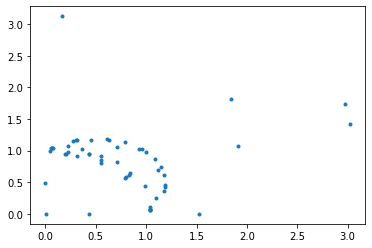

In [3]:
fig, ax = plt.subplots()
ax.plot(train_x[:, 0], train_x[:, 1],'.')

plt.show()

In [5]:
print(train_y)
print(train_c)

tensor([[1.9155],
        [3.0208],
        [1.8412],
        [2.9763],
        [0.1623],
        [1.5268],
        [1.1159],
        [   nan],
        [   nan],
        [   nan],
        [0.3629],
        [0.7131],
        [0.9858],
        [0.2205],
        [   nan],
        [0.0694],
        [1.0958],
        [1.0416],
        [0.9272],
        [0.4482],
        [0.7117],
        [1.1765],
        [1.0392],
        [0.6350],
        [0.0720],
        [0.5479],
        [0.9964],
        [0.3165],
        [0.8414],
        [1.1864],
        [   nan],
        [0.4309],
        [   nan],
        [1.0383],
        [0.2287],
        [0.2066],
        [0.0613],
        [0.7849],
        [0.8252],
        [1.0876],
        [0.3078],
        [0.8023],
        [1.1873],
        [0.1971],
        [1.0385],
        [0.6098],
        [0.5516],
        [0.5482],
        [0.9619],
        [0.2702],
        [1.1497],
        [1.0386],
        [0.7929],
        [0.0591],
        [1.1803]], dtype=tor